In [2]:
# Import package
import h5py
import numpy as np
import sigpy.plot as pl
import sigpy as sp
%matplotlib notebook

In [3]:
import cfl

In [4]:
import matplotlib.pyplot as plt

In [5]:
#read dataset: brain dataset
h5_dataset_brain = h5py.File('rawdata_brain_radial_96proj_12ch.h5', 'r')

In [6]:
h5_dataset_rawdata_name = list(h5_dataset_brain.keys())[0]
h5_dataset_trajectory_name = list(h5_dataset_brain.keys())[1]

trajectory = h5_dataset_brain.get(h5_dataset_trajectory_name).value
rawdata = h5_dataset_brain.get(h5_dataset_rawdata_name).value

In [48]:
trajectory.shape

(3, 512, 96)

In [49]:
coor = trajectory[:2,:,:].transpose((1,2,0))

In [52]:
coor.shape

(512, 96, 2)

In [15]:
image = cfl.readcfl("img_igrid_brain")

In [20]:
image_sos = sp.util.rss(image,3)

In [37]:
sens_maps = image[:,:,0,:]/image_sos

<IPython.core.display.Javascript object>


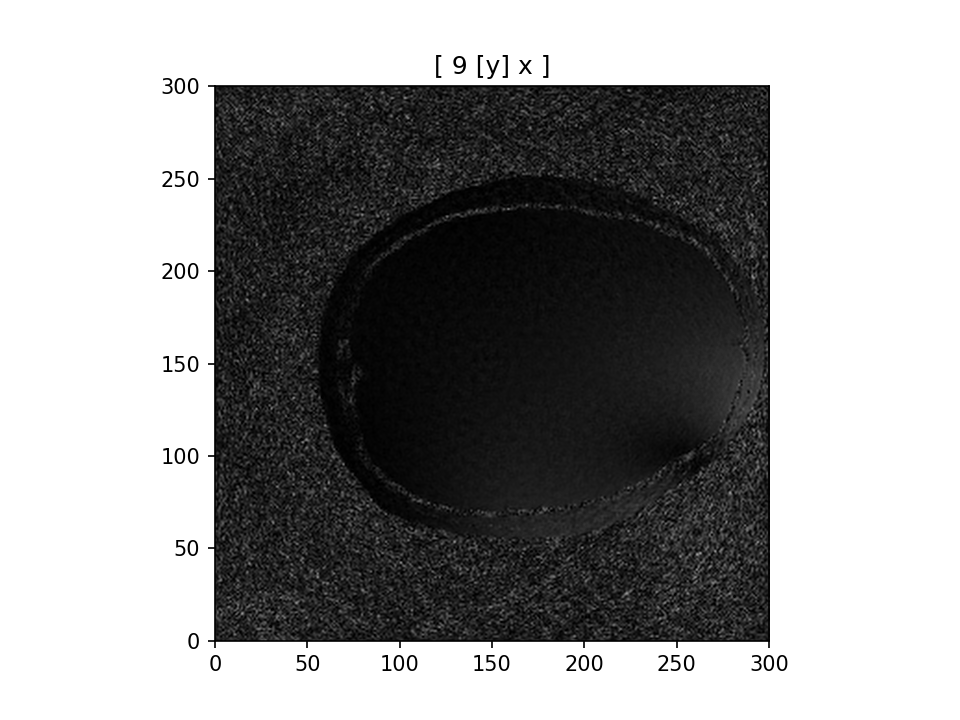

In [42]:
pl.ImagePlot(sens_maps_t)

In [67]:
sens_maps_t = sens_maps.transpose((2,0,1))

In [68]:
S = sp.linop.Multiply((1,300,300),sens_maps_t)

In [69]:
NUFFT = sp.linop.NUFFT((12,300,300),coor)

In [70]:
Operator = NUFFT*S

In [71]:
rawdata_brain = rawdata[0,:,:,:].transpose((2,0,1))

In [72]:
Operator.oshape

[12, 512, 96]

In [78]:
img_rec = sp.app.LinearLeastSquares(Operator,rawdata_brain,max_iter=3).run()

LinearLeastSquares: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s, resid=4.32E-02]


In [73]:
im = Operator.H*rawdata_brain

<IPython.core.display.Javascript object>


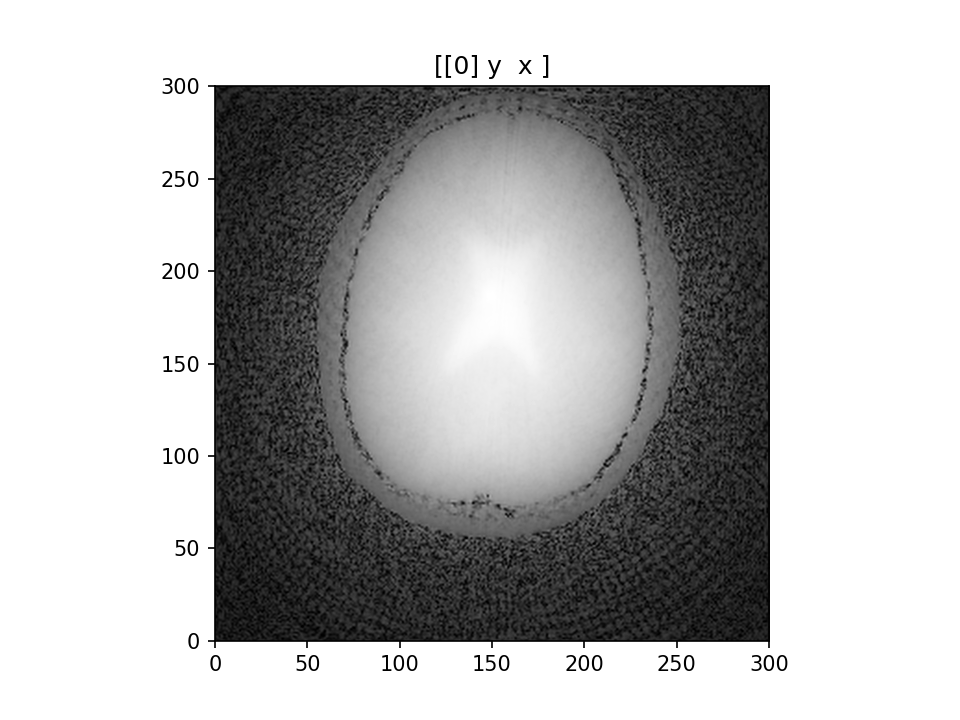

In [74]:
pl.ImagePlot(im)

<IPython.core.display.Javascript object>


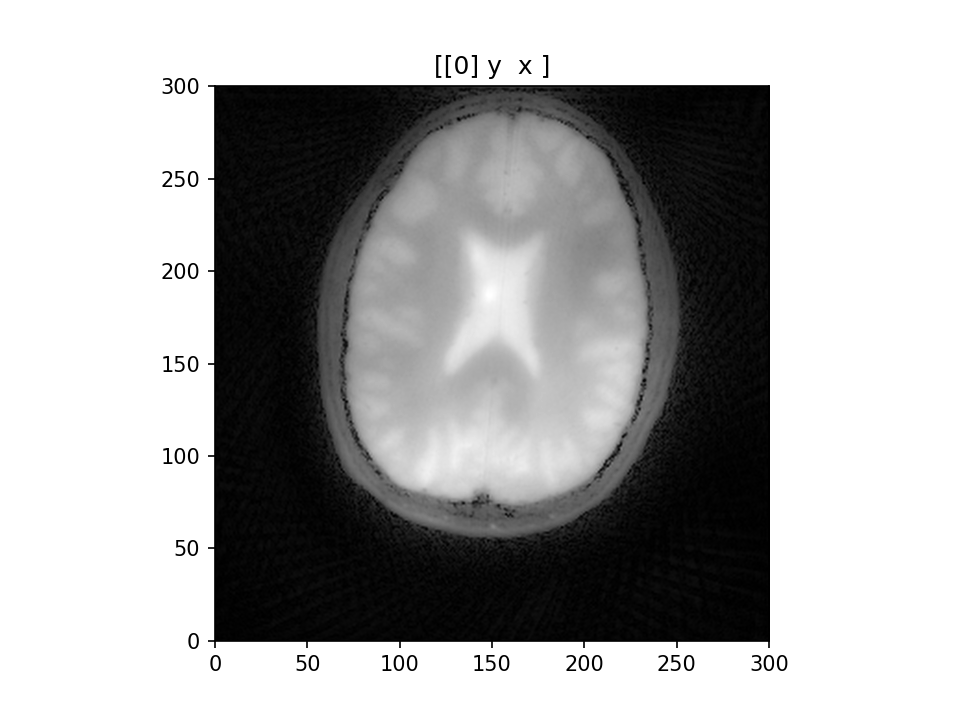

In [80]:
pl.ImagePlot(img_rec)

<IPython.core.display.Javascript object>


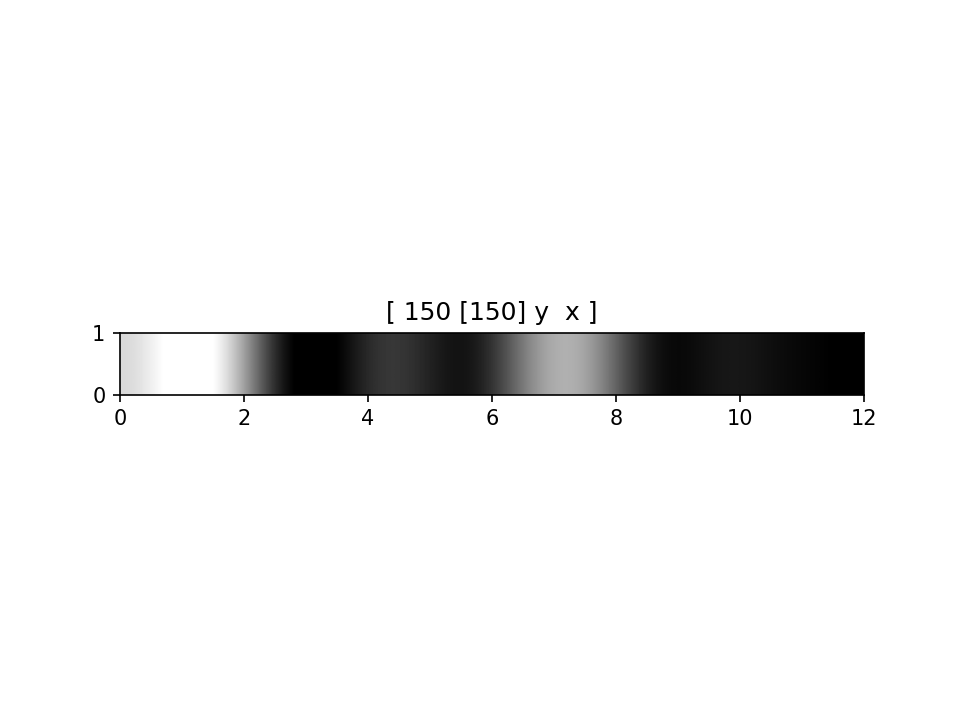

In [76]:
pl.ImagePlot(image)

<IPython.core.display.Javascript object>


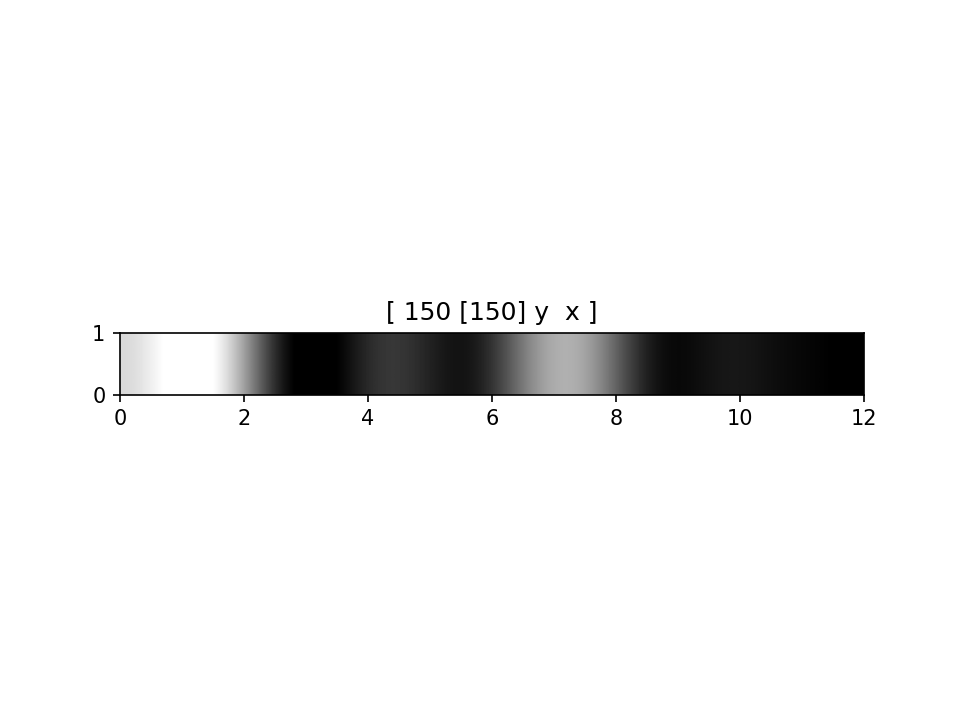

In [79]:
pl.ImagePlot(image)

In [9]:
cfl.writecfl("trajectory_brain",trajectory)
cfl.writecfl("rawdata_brain",rawdata)

In [7]:
rawdata.shape

(1, 512, 96, 12)

<IPython.core.display.Javascript object>


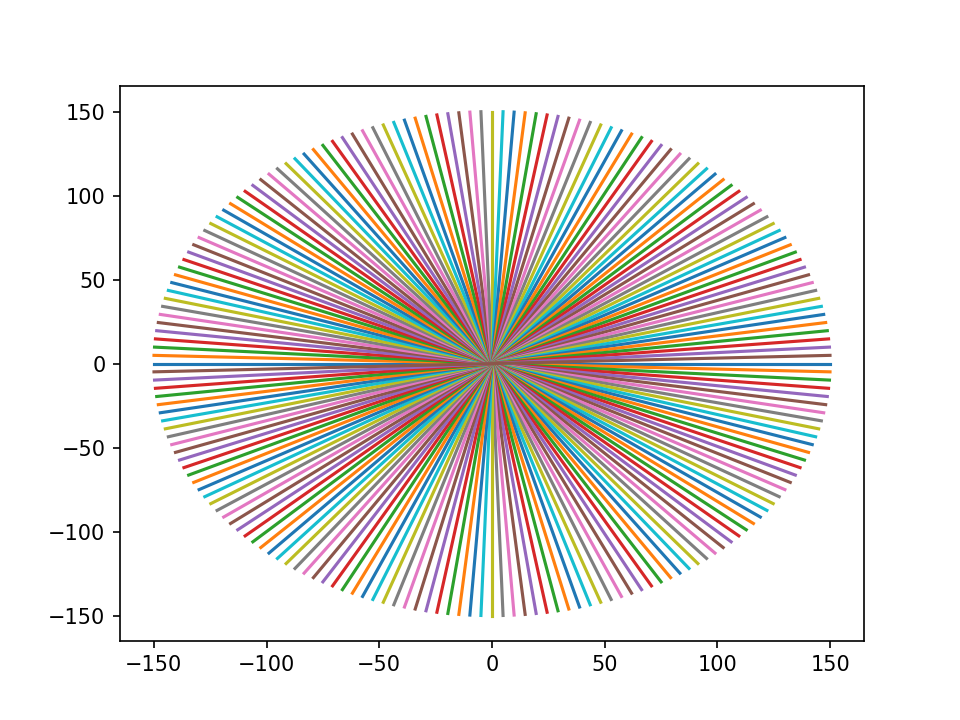

In [8]:
plt.plot(trajectory[0,:,:],trajectory[1,:,:])